In [57]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import shap
import pickle
import warnings


# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# === Function Library ===


In [58]:
def missing_value_report(df):
    """
    Generate a comprehensive report of missing values in the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame with potential missing values.

    Returns:
        dict: Dictionary containing missing value statistics.
    """
    report = {}

    # Calculate basic statistics
    total_missing = df.isna().sum().sum()
    missing_per_col = df.isna().mean() * 100
    cols_with_missing = missing_per_col[missing_per_col > 0].sort_values(ascending=False)

    report['total_missing'] = total_missing
    report['missing_per_col'] = missing_per_col
    report['cols_with_missing'] = cols_with_missing

    # Print basic information
    print(f"Total missing values in dataset: {total_missing}")
    print("\nColumns with missing values (sorted by % missing):")
    print(cols_with_missing)

    # Heatmap visualization of missing data
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Missing Values Heatmap", fontsize=16)
    plt.show()

    # Bar plot of missing percentages
    plt.figure(figsize=(12, 6))
    cols_with_missing.plot(kind='bar')
    plt.title("Percentage of Missing Values by Column", fontsize=16)
    plt.ylabel("Percentage Missing")
    plt.axhline(30, color='red', linestyle='--', label='30% Threshold')
    plt.legend()
    plt.show()

    return report

# 🟩 Step 1: Detect Missing Data



In [59]:
df = pd.read_parquet('/content/drive/MyDrive/itHub/well_data')
pd.set_option('display.max_columns', None)

# check for small data frame
df = df.head(10000)

# Count missing values in each column
show_missing_info(df)

🔢 Missing value count per column:
 Record_ID                      0
API_Well_ID                    0
LONG_deg                       0
LAT_deg                        0
DateTime                       0
Days_Age_Well_days             0
Drilling_Direction             0
Depth_Measured_m               0
Depth_Bit_m                    0
Layer_ID                       0
Formation_Type                 0
Layer_Type                     0
Clay_Mineralogy_Type           0
Clay_Content_Percent_%         0
Formation_Permeability_mD      0
Porosity_Formation_%           0
Fractures_Presence             0
Phase_Operation                0
Weight_on_Bit_kg               0
ROP_m_hr                       0
RPM_rev_min                    0
Torque_Nm                      0
Mud_Type                       0
Mud_Weight_In_ppg              0
Mud_Weight_Out_ppg             0
Mud_Temperature_In_C           0
Mud_Temperature_Out_C          0
In_Rate_Flow_Mud_l_min         0
Out_Rate_Flow_Mud_l_min        0
Viscosit

# 🟨 Step 2: Randomly Inject Missing Values

Total missing values in dataset: 22000

Columns with missing values (sorted by % missing):
Record_ID                      5.0
API_Well_ID                    5.0
LONG_deg                       5.0
LAT_deg                        5.0
DateTime                       5.0
Days_Age_Well_days             5.0
Drilling_Direction             5.0
Depth_Measured_m               5.0
Depth_Bit_m                    5.0
Layer_ID                       5.0
Formation_Type                 5.0
Layer_Type                     5.0
Clay_Mineralogy_Type           5.0
Clay_Content_Percent_%         5.0
Formation_Permeability_mD      5.0
Porosity_Formation_%           5.0
Fractures_Presence             5.0
Phase_Operation                5.0
Weight_on_Bit_kg               5.0
ROP_m_hr                       5.0
RPM_rev_min                    5.0
Torque_Nm                      5.0
Mud_Type                       5.0
Mud_Weight_In_ppg              5.0
Mud_Weight_Out_ppg             5.0
Mud_Temperature_In_C           5.0

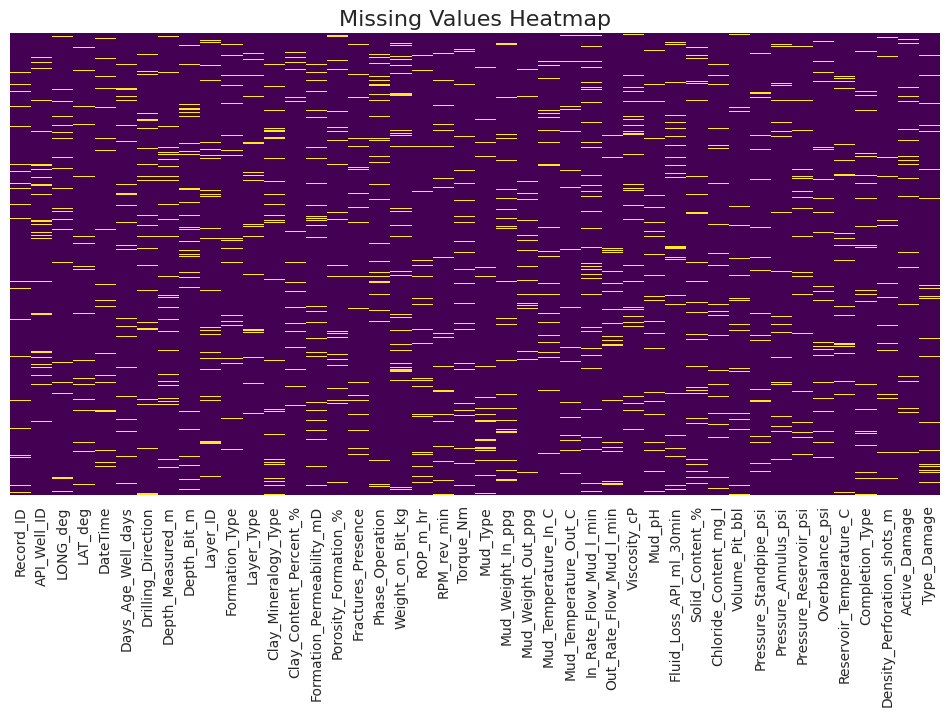

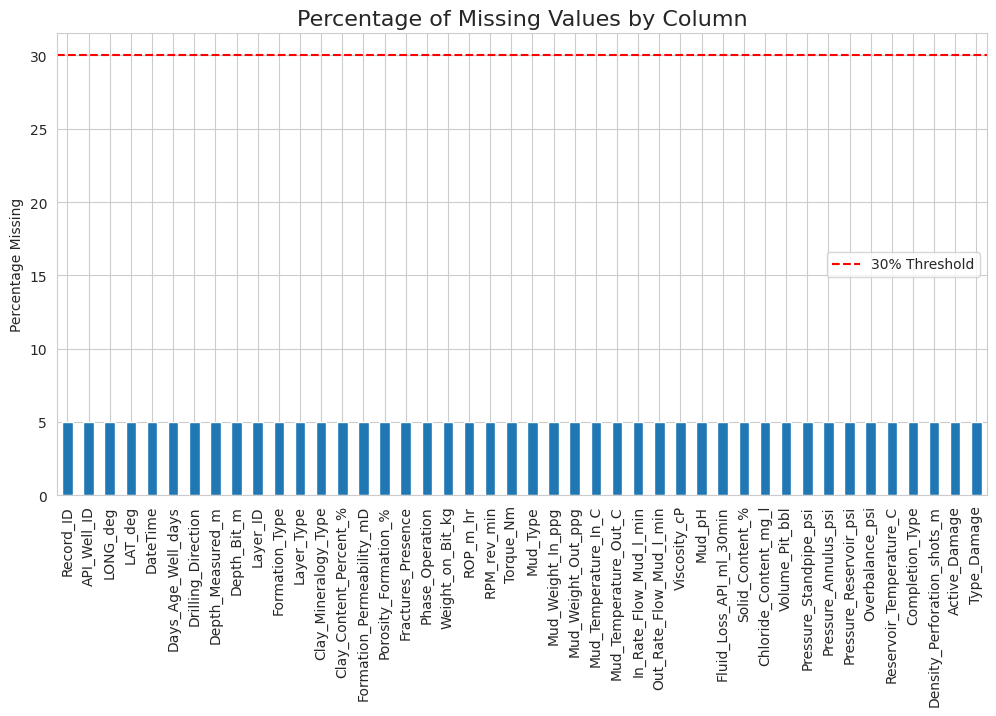

{'total_missing': np.int64(22000),
 'missing_per_col': Record_ID                      5.0
 API_Well_ID                    5.0
 LONG_deg                       5.0
 LAT_deg                        5.0
 DateTime                       5.0
 Days_Age_Well_days             5.0
 Drilling_Direction             5.0
 Depth_Measured_m               5.0
 Depth_Bit_m                    5.0
 Layer_ID                       5.0
 Formation_Type                 5.0
 Layer_Type                     5.0
 Clay_Mineralogy_Type           5.0
 Clay_Content_Percent_%         5.0
 Formation_Permeability_mD      5.0
 Porosity_Formation_%           5.0
 Fractures_Presence             5.0
 Phase_Operation                5.0
 Weight_on_Bit_kg               5.0
 ROP_m_hr                       5.0
 RPM_rev_min                    5.0
 Torque_Nm                      5.0
 Mud_Type                       5.0
 Mud_Weight_In_ppg              5.0
 Mud_Weight_Out_ppg             5.0
 Mud_Temperature_In_C           5.0
 Mud_Tempe

In [60]:
# Set the missing value fraction (e.g., 5%)
missing_fraction = 0.05

# Inject missing values randomly into numeric columns
for col in df.columns:
  # Calculate how many values to set as NaN
  n_missing = int(missing_fraction * len(df))

  # Randomly choose row indices to set as NaN
  missing_indices = np.random.choice(df.index, n_missing, replace=False)

  # Apply NaN to selected cells
  df.loc[missing_indices, col] = np.nan

missing_value_report(df)

# 🟦 Step 3 (Extended): Drop Columns/Rows Based on Missing Value Threshold


In [61]:
# Step 1: Drop irrelevant or mostly-null columns (column-wise drop)
# These columns either don't help in prediction or are filled with NaNs
columns_to_drop = [
    'Record_ID',  # Just a unique ID
    'API_Well_ID',  # Another unique ID
    'DateTime',  # Time is too granular here
    'Phase_Operation',  # Not predictive for damage
    'Completion_Type',  # Mostly empty or not informative
    'Type_Damage'  # This is the label, keep it for training; drop only if not used
]
df.drop(columns=columns_to_drop, inplace=True)

# Step 2: Drop rows with missing values in important columns (row-wise drop)
# These features are important for model prediction
important_features = [
    'Clay_Content_Percent_%',
    'Formation_Permeability_mD',
    'Porosity_Formation_%',
    'Weight_on_Bit_kg',
    'ROP_m_hr',
    'RPM_rev_min',
    'Torque_Nm',
    'Mud_Weight_In_ppg',
    'Mud_Temperature_In_C',
    'Pressure_Standpipe_psi',
    'Pressure_Annulus_psi'
]

# Drop rows where any of the important features are missing
df.dropna(subset=important_features, inplace=True)

# 🟪 Step 4 (Extended): Train and Apply the Best Imputation Model for Each Column


In [62]:
results = {}

for col in df.columns:
    # Skip columns with no missing values
    if df[col].isnull().sum() == 0:
        continue

    print(f"Processing column: {col}")

    # Split data into rows where target column is not missing (train) and missing (test)
    train_data = df[df[col].notnull()]
    test_data = df[df[col].isnull()]

    # Separate features and target variable for training
    X_train = train_data.drop(columns=[col])
    y_train = train_data[col]
    X_test = test_data.drop(columns=[col])

    # Select only numeric columns from features for the model
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64', 'bool']).columns
    X_train = X_train[numeric_cols]
    X_test = X_test[numeric_cols]

    # Check if target is categorical (classification) or numerical (regression)
    if y_train.dtype == 'object' or y_train.dtype.name == 'category':
        # Encode target labels if categorical
        le_y = LabelEncoder()
        y_train = le_y.fit_transform(y_train)
        is_classification = True
    else:
        is_classification = False

    # Choose a model: RandomForestClassifier for classification, RandomForestRegressor for regression
    if is_classification:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict missing values
    preds = model.predict(X_test)

    # If classification, inverse transform the predicted labels back to original categories
    if is_classification:
        preds = le_y.inverse_transform(preds.astype(int))

    # Fill the missing values in the original dataframe
    df.loc[df[col].isnull(), col] = preds

    # Save model and count of missing values for this column
    results[col] = {
        'model': model,
        'num_missing': len(test_data)
    }

print("Imputation completed.")

Processing column: LONG_deg
Processing column: LAT_deg
Processing column: Days_Age_Well_days
Processing column: Drilling_Direction
Processing column: Depth_Measured_m
Processing column: Depth_Bit_m
Processing column: Layer_ID
Processing column: Formation_Type
Processing column: Layer_Type
Processing column: Clay_Mineralogy_Type
Processing column: Fractures_Presence
Processing column: Mud_Type
Processing column: Mud_Weight_Out_ppg
Processing column: Mud_Temperature_Out_C
Processing column: In_Rate_Flow_Mud_l_min
Processing column: Out_Rate_Flow_Mud_l_min
Processing column: Viscosity_cP
Processing column: Mud_pH
Processing column: Fluid_Loss_API_ml_30min
Processing column: Solid_Content_%
Processing column: Chloride_Content_mg_l
Processing column: Volume_Pit_bbl
Processing column: Pressure_Reservoir_psi
Processing column: Overbalance_psi
Processing column: Reservoir_Temperature_C
Processing column: Density_Perforation_shots_m
Processing column: Active_Damage
Imputation completed.


# ✅ Summary Printer Code

In [68]:
null_counts = df.isnull().sum()
null_counts

,0
LONG_deg,0
LAT_deg,0
Days_Age_Well_days,0
Drilling_Direction,0
Depth_Measured_m,0
Depth_Bit_m,0
Layer_ID,0
Formation_Type,0
Layer_Type,0
Clay_Mineralogy_Type,0
